In [2]:
## Unsupervised Learning untuk Data Geospasial
## rencananya akan membagi / mengkelompokan nilai
## R = 0 - 255
## G = 0 - 255
## B = 0 - 255
## nanti kita cari apakah dia akan menjadi berapa cluster/kelas dari tiap warna tersebut

## install rasterio
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.4 MB/s eta 0:00:00


In [3]:
## import library
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [4]:
## Input Data
file_path = "/content/drive/MyDrive/training_ml_geospasial_geosoftware/Sesi7UnsuperviseDataGeospasial/Data/landsat8_dki_jakpus_2017.tif"



In [5]:
## Membaca data raster
with rasterio.open(file_path) as src:
    band_data = src.read()
    image = src.read([2,3,4])

In [6]:
## memeriksa jumlah data
band_data.shape

(19, 349, 334)

In [7]:
## memeriksa jumlah data
image.shape

(3, 349, 334)

In [8]:
## Check Dimensi Gambar
bands, height, width = image.shape

In [9]:
print(bands)
print(height)
print(width)

3
349
334


In [11]:
## Preprocessing Data
blue = image[0].astype(float)
green = image[1].astype(float)
red = image[2].astype(float)

In [12]:
## preprocessing menghilangkan data nan ke 0
## agar bisa diproses oleh ML karena selain data numeric tidak dapat diproses atau dapat mengganggu
for band in [blue, green, red]:
    band[np.isnan(band)] = 0

In [13]:
## Persiapan Data
## merubah nilai 3D (Band, Height, Width) -> menjadi data tabular
image_reshape = image.reshape(bands, height * width).T

In [15]:
## preprocessing menghilangkan data nan ke 0
## agar bisa diproses oleh ML karena selain data numeric tidak dapat diproses atau dapat mengganggu
valid_pixels = np.where(~np.isnan(image_reshape).any(axis=1))

In [22]:
image_valid = image_reshape[valid_pixels]
image_valid

array([[10542. , 11211. , 11221. ],
       [10321. , 11178. , 11163. ],
       [10231. , 11135. , 11212. ],
       ...,
       [ 8544. ,  9347.5,  9250.5],
       [ 8541. ,  9336. ,  9241. ],
       [ 8479.5,  9401.5,  9204.5]])

In [17]:
## Normalisasi Data
## digunakan untuk range data yang berbeda jauh
min_value = image_valid.min(axis=0)
max_value = image_valid.max(axis=0)

In [18]:
range_value = max_value - min_value

In [19]:
## agar pembagian menghindari tak hingga, untuk jaga2 saja
range_value[range_value==0] = 1

In [20]:
## Normalisasi
image_normalized = (image_valid - min_value) / range_value

In [21]:
image_normalized

array([[0.29420559, 0.22929575, 0.23163926],
       [0.28419336, 0.2275919 , 0.22874938],
       [0.28011598, 0.22537175, 0.23119083],
       ...,
       [0.20368776, 0.13308034, 0.1334579 ],
       [0.20355185, 0.13248658, 0.13298455],
       [0.20076564, 0.13586844, 0.13116592]])

In [23]:
## Evaluasi Nilai K
## Menentukan Nilai K (jumlah cluster)

## Metoda 1. Elbow
## menggunakan beberapa data karena kalau semua nanti proses cukup berat, kita gunakan sample
sample = resample(image_normalized, n_samples=1000, random_state=99)

In [27]:
sse = []
sil = []

## fungsi sse - elbow
for k in range(2,6)  :
  model = KMeans(n_clusters=k, random_state=99)
  model.fit(image_normalized)
  sse.append(model.inertia_)
  sil.append(silhouette_score(sample, model.predict(sample)))

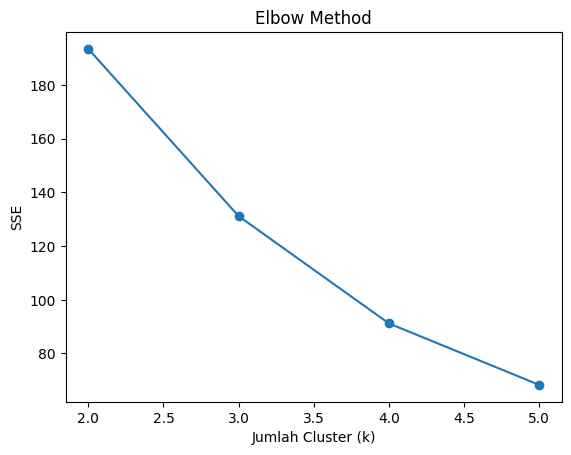

In [28]:
## Visualisasi
## Plot Elbow Method

plt.figure()
plt.plot(range(2,6), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('SSE')
plt.show()


## cara menentukan elbow nya cari selisi antar K
## Nilai dimana titik - titik selanjutnya paling kecil dari yg lain
## ini K = 4
## Karena selisih K 4 dengan K 5 = ~20 (paling kecil dari yg lain)
## K 2 - K3 = ~60
## K 3 - K4 = ~40

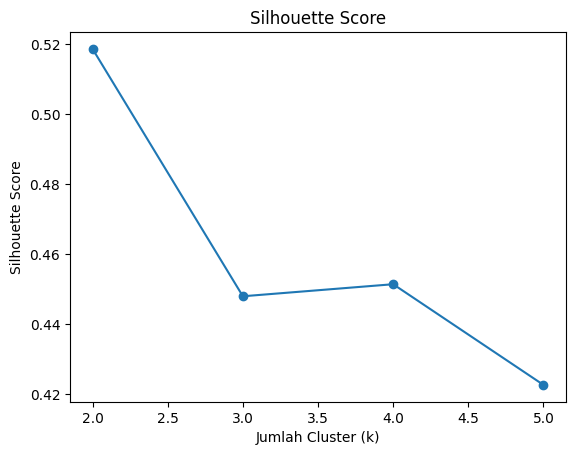

In [29]:
## Plot Shilloute Score
plt.figure()
plt.plot(range(2,6), sil, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.show()

## nah lo sekarang menuru shilloute score ada 2 nilai yaitu K2 dan K4
## tapi dari shilloute score ini menambah kenyakinan bahwan K3 bukan K yg dicari
## sekarang kalau dibagi 2, nanti data terlalu general
## nah kenapa kita ambil nilai K4 karena tidak terlalu umum, nilai shilloute score cukup tinggi dan nilai menurut elbow juga okay


In [30]:
## membuat model final
## memilih jumlah cluster K=4

jumlah_cluster = 4
kmeans = KMeans(n_clusters=jumlah_cluster, random_state=99)
cluster_labels = kmeans.fit_predict(image_normalized)

In [31]:
## Membuat Citra Hasil Segmentasi

## membuat array label penuh dengan nilai -1 (untuk pixel yg tidak valid)
all_labels = -1 * np.ones(image_reshape.shape[0], dtype=int)

## masukan hasil label ke pixel valid
all_labels[valid_pixels] = cluster_labels

## ubah bentuk array label menjadi 2d untuk visual dimensi gambar
clustered_image = all_labels.reshape(height, width)

In [32]:
## Visualisasi Hasil

masked_image = np.where(clustered_image == -1, np.nan, clustered_image)

In [33]:
## buat colormap dengan jumlah sesuai cluster
cmap = plt.cm.tab20
custom_cmap = mcolors.ListedColormap(cmap.colors[:jumlah_cluster])

(np.float64(-0.5), np.float64(333.5), np.float64(348.5), np.float64(-0.5))

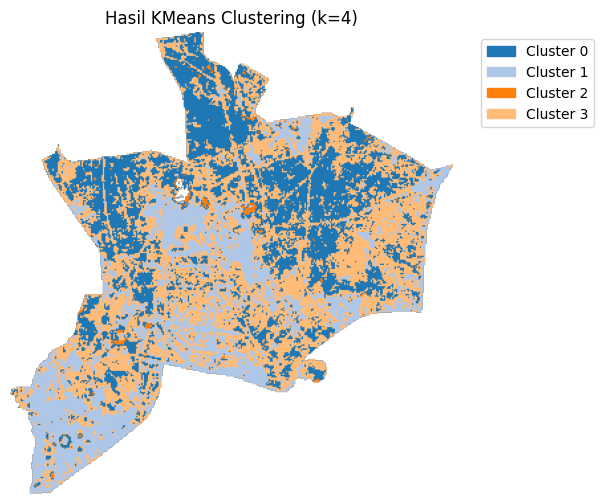

In [34]:
plt.figure(figsize=(8, 6))
plt.imshow(masked_image, cmap=custom_cmap)
plt.title(f'Hasil KMeans Clustering (k={jumlah_cluster})')
legend_labels = [f'Cluster {i}' for i in range(jumlah_cluster)]
legend_patches = [mpatches.Patch(color=custom_cmap.colors[i],
label=legend_labels[i])
for i in range(jumlah_cluster)]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1),
loc='upper left')
plt.axis('off')

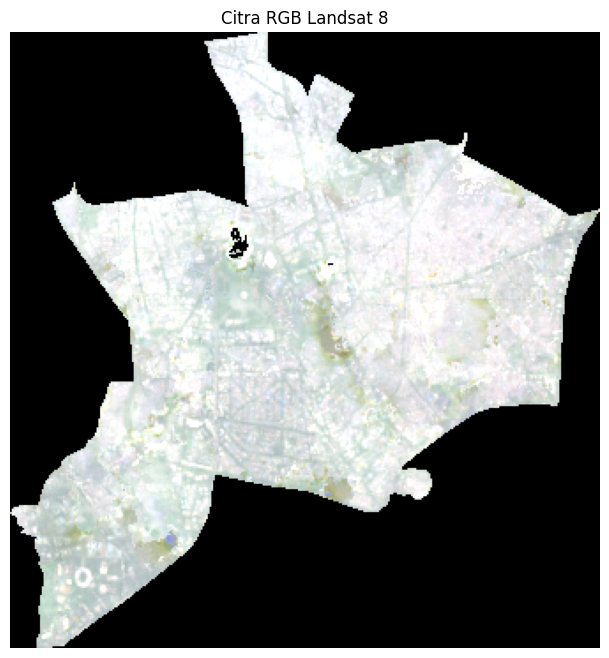

In [35]:
#Fungsi normalisasi ke rentang 0-1 agar citra dapat ditampilkan dengan baik
def normalize(band):
  low, high = np.percentile(band, (5, 95))
  band_clipped = np.clip(band, low, high)
  return (band_clipped - low) / (high - low)
red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)
# Gabungkan menjadi citra RGB (tinggi x lebar x 3)
rgb_image = np.dstack((red_n, green_n, blue_n))
# Tampilkan citra RGB
plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)
plt.title('Citra RGB Landsat 8')
plt.axis('off')
plt.show()

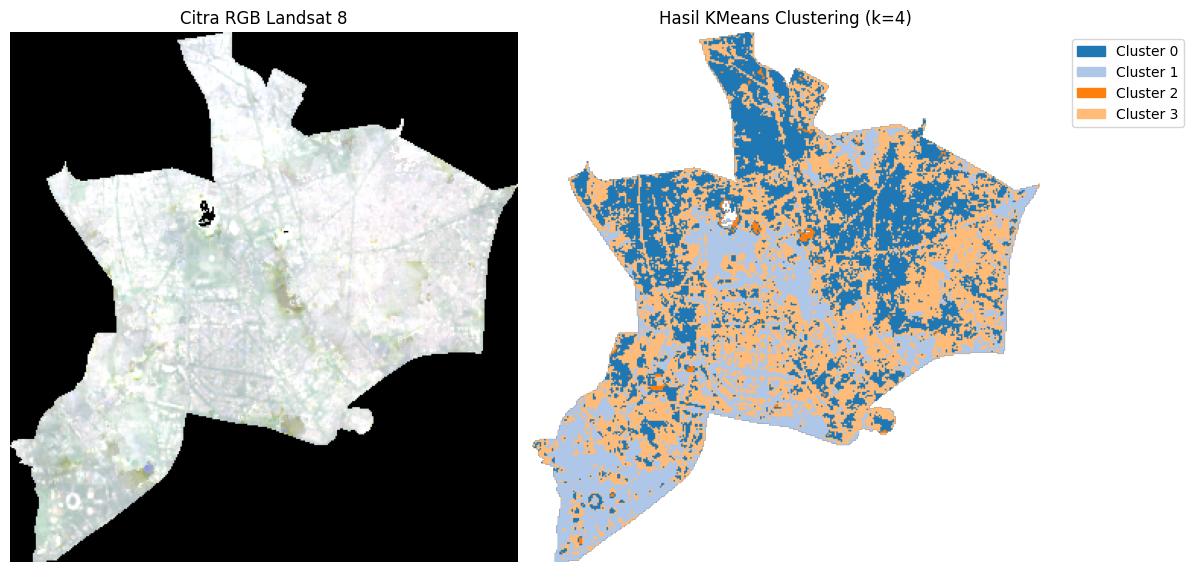

In [36]:
# Tampilkan hasil
plt.figure(figsize=(12, 6))
# Gambar Asli
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title('Citra RGB Landsat 8')
plt.axis('off')
# Gambar Segmentasi
plt.subplot(1, 2, 2)
plt.imshow(masked_image, cmap=custom_cmap)
plt.title(f'Hasil KMeans Clustering (k={jumlah_cluster})')
plt.axis('off')
# Tambahkan legenda
legend_labels = [f'Cluster {i}' for i in range(jumlah_cluster)]
legend_patches = [mpatches.Patch(color=custom_cmap.colors[i],
label=legend_labels[i])
for i in range(jumlah_cluster)]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1),
loc='upper left')
plt.tight_layout()
plt.show()

## Cluster 0 = lahan terbuka
## Cluster 1 = noise / awan
## Cluster 2 = Tanah perkotaan
## Cluster 3 = Vegetasi

In [38]:
## --- Simpan Hasil Segmentasi ke GeoTIFF ---
import rasterio
output_path = '/content/drive/MyDrive/training_ml_geospasial_geosoftware/MiniProject2/Hasil_SegmentasiCitra-Landsat.tif'

# Ambil metadata dari file asli
with rasterio.open(file_path) as src:
  meta = src.meta.copy()

# Update metadata untuk hasil klasifikasi
meta.update({
    'count': 1, # hanya 1 band (label hasil KMeans)
    'dtype': 'int32', # tipe data hasil klasifikasi
    'nodata': -1 # nilai untuk pixel yang tidak valid
})

# Simpan clustered_image sebagai file GeoTIFF
with rasterio.open(output_path, 'w', **meta) as dst:
  dst.write(clustered_image.astype('int32'), 1) # tulis ke band 1